In [1]:
import yfinance as yf
import pandas as pd
from datetime import date
import quandl
import math
import numpy as np
import os
#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#importing required libraries
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [42]:
tick = yf.Ticker("XXII")
stock = tick.history(period='max')
#Only use 4 years of data
today = date.today()
formed_date = today.strftime("%Y-%m-%d")
stock = stock.loc['2002-01-01':formed_date]
stock.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-11-26,0.980,1.0200,0.910,1.02,2390100,0,0
2019-11-27,0.971,1.0600,0.948,1.05,1524300,0,0
2019-11-29,1.050,1.0600,0.995,1.03,561900,0,0
2019-12-02,1.020,1.0400,1.000,1.03,608300,0,0
2019-12-03,1.010,1.0199,0.990,1.00,650711,0,0


In [43]:
#Make additional columns for the regressor

stock['Change'] = stock['Open'] - stock['Close']
stock['Intraday_Change'] = stock['High'] - stock['Low']
stock['Movement'] = stock['High'] - stock['Low'] / stock['High']
stock['Day_of_Week'] = stock.index.dayofweek
stock['Day_of_Year'] = stock.index.dayofyear
stock['y'] = stock['Close']
stock['Date'] = stock.index
stock['Year'] = stock['Date'].dt.year
stock['Month'] = stock['Date'].dt.month
stock.fillna(0)
stock.isnull().sum()

Open               0
High               0
Low                0
Close              0
Volume             0
Dividends          0
Stock Splits       0
Change             0
Intraday_Change    0
Movement           0
Day_of_Week        0
Day_of_Year        0
y                  0
Date               0
Year               0
Month              0
dtype: int64

In [44]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_val), y_val),
                m.score(X_train, y_train), m.score(X_val, y_val)]
    print(f"rmse train {res[0]}, rmse val {res[1]}, r^2 train {res[2]}, r^2 val {res[3]}")

In [45]:
TOTAL = stock.count()[0]
N_VALID = 120 # Three months
TRAIN = TOTAL - N_VALID
params = ['Open', 'Close', 'High', 'Low', 'Volume', 'Change', 'Intraday_Change', 'Movement', 
          'Dividends', 'Year', 'Month', 'Day_of_Week', 'Day_of_Year']
stock_data = stock[params]

X_df = stock_data
y_df = stock['y']
X_train, X_val = X_df[:TRAIN], X_df[TRAIN:]
y_train, y_val = y_df[:TRAIN], y_df[TRAIN:]

model = RandomForestRegressor(n_estimators=80, bootstrap=True, min_samples_leaf=25)
model.fit(X_train, y_train)
estimator = model.estimators_[0]
print_score(model)
print("Mean of y train ", y_train.mean())

rmse train 0.08279247914237826, rmse val 0.022215062538403694, r^2 train 0.9909532794245004, r^2 val 0.9954802281957852
Mean of y train  1.510952583933227


In [46]:
for num in range(model.feature_importances_.size):
    print(params[num])
    print(model.feature_importances_[num]) 

Open
0.00019688812547032655
Close
0.9971076600267829
High
0.0002678180610045221
Low
0.00220831290530528
Volume
8.069703398182487e-07
Change
1.0657888848850577e-08
Intraday_Change
1.7236710769782763e-07
Movement
0.00021821498173841929
Dividends
0.0
Year
3.58172987789665e-08
Month
0.0
Day_of_Week
8.861188176600908e-09
Day_of_Year
7.122587504231765e-08


120
[1.98066422 2.15819897 2.01684521 2.05307557 2.00504825 1.9407865
 1.99680881 1.91107363 1.99680881 2.02600144 2.08685135 1.99680881
 2.03284714 2.00504825 1.9407865  2.00504825 2.00504825 1.99680881
 1.9407865  1.99680881 1.98066422 1.9407865  1.91107363 1.88976216
 1.91107363 1.88976216 1.88976216 1.86949337 1.85726607 1.85565794
 1.85565794 1.64001033 1.6384819  1.35319861 1.63653959 1.44762808
 1.6384819  1.4975304  1.64001033 1.90202176 1.86949337 1.87473714
 1.86949337 1.85565794 1.90202176 1.87473714 1.86949337 1.85565794
 1.99680881 2.00504825 1.91107363 1.85565794 1.9407865  1.98066422
 1.98066422 1.90202176 1.92285391 2.02600144 2.08685135 2.0143742
 2.11998352 2.21046007 2.32028539 2.34770108 2.28755602 2.21693294
 2.23601181 2.25446845 2.35658    2.27791762 2.22643152 2.30966957
 2.3973902  2.39952297 2.26859077 2.13882988 2.12576644 2.05984361
 2.19236541 2.12652819 2.07429965 2.12652819 2.05383732 2.02676319
 2.00504825 2.01684521 2.00504825 2.00504825 2.05307557 2.13

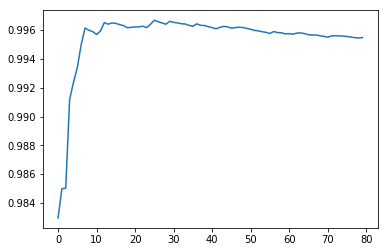

In [47]:
print(model.predict(X_val).size)
print(model.predict(X_val))

preds = np.stack([t.predict(X_val) for t in model.estimators_])
print(f"Trees: {len(preds[:,0])},", f"Mean of 0th row for prediction from all trees: : {np.mean(preds[:,0])},", f"Actual y: {y_val[0]}")

plt.plot([metrics.r2_score(y_val, np.mean(preds[:i+1], axis=0)) for i in range(80)]);

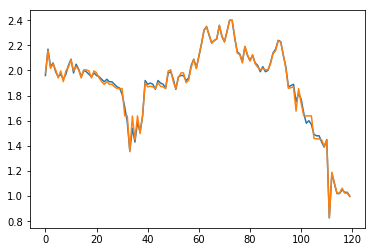

In [53]:
close = stock_data['Close'].values

plt.plot(close[-120:])
plt.plot(model.predict(X_val))

In [49]:
from sklearn.tree import export_graphviz

export_graphviz(estimator,
                feature_names=X_df.columns,
                filled=True,
                rounded=True)

os.system('dot -Tpng tree.dot -o tree.png')


512